In [10]:
import numpy as np
import matplotlib.pyplot as plt
import time



# Simulation for states and actions
class Simulation(object):
    def __init__(self, k, mean=0, sigma=0.1, seed=0):
        self.k = k # Number of arms
        self.mean = mean        
        self.sigma = sigma      

        self.actArr = np.zeros(k)   # Action values
        self.optim = 0                  # Store optimal value for greedy
        self.reset()

        self.seed = seed
        np.random.seed(self.seed)

    # Reset Simulation for next iteration
    def reset(self):
        # Identify the maximum value in action array
        self.optim = np.argmax(self.actArr)

        self.actArr = np.zeros(self.k)

    def step_reward(self):
        np.random.seed(self.seed)

        # Random walk each action value
        self.actArr = self.actArr + np.random.normal(self.mean, self.sigma, self.k)
        self.seed += 12

        self.optim = np.argmax(self.actArr)

# Agent class who returns an action given a state
class Agent(object):
    def __init__(self, k, action_value="sample_average", epsilon=0, alpha=0.1):
        self.k = k      # Number of arms
        self.epsilon = epsilon      # Epsilon probability
        self.alpha = alpha

        self.time_step = 0                    # Time Step t
        self.last_action = None               # Store last action

        self.n_action = np.zeros(k)          # Count of actions taken at time t
        self.last_action_value = np.zeros(k)
        self.r_sum = np.zeros(k)             # Sums number of rewards
        self.val_estimates = np.zeros(k)     # Action value estimates
        self.action_value = action_value
        

    def __str__(self):
        return self.action_value

    # Epsilon-greedy action scheme
    # If greedy, take max action-value estimate
    # If not, take random action
    def action(self):
        # Not greedy?
        randProb = np.random.random()   # Pick random probability between 0-1
        if randProb < self.epsilon:
            a = np.random.choice(len(self.val_estimates))    # Select random action

        # Greedy
        else:
            max_action = np.argmax(self.val_estimates)
            action = np.where(self.val_estimates == np.argmax(self.val_estimates))[0] # Take the max action

            # If multiple actions contain the same value, randomly select an action
            if len(action) == 0:
                a = max_action
            else:
                a = np.random.choice(action)

        # save last action in variable, and return result
        self.last_action = a
        return a

    ##########################################
    # Action value method:
    # Sample average
    def AV_sample_average(self, reward):
        # Calculate the new action-value using:
        # Q_n+1 = r_sum/n_action

        At = self.last_action

        self.n_action[At] += 1       # Add 1 to action selection
        self.r_sum[At] += reward     # Add reward to sum array
        self.time_step += 1          # Increase time step

        # Calculate new action-value
        self.val_estimates[At] = self.r_sum[At]/self.n_action[At]

    # Action value method:
    # Incrementally computed
    def AV_increment(self, reward):
        # Calculate the new action value using:
        # Q_n+1 = Q_n + (reward - Q_n)/n_action
        
        At = self.last_action
        
        self.n_action[At] += 1       # Add 1 to action selection
        self.time_step += 1          # Increase time step

        self.val_estimates[At] = self.val_estimates[At] + (reward - self.val_estimates[At])/self.n_action[At]

    # Action value method:
    # constant step
    def AV_constant_step(self, reward):
        # Calculate the new action value using:
        # Q_n+1 = Q_n + alpha(reward - Q_n)        
        At = self.last_action
        
        self.n_action[At] += 1       # Add 1 to action selection
        self.time_step += 1          # Increase time step

        self.val_estimates[At] = self.val_estimates[At] + self.alpha*(reward - self.val_estimates[At])

    # Reset all variables for next iteration
    def reset(self):
        self.time_step = 0                    # Time Step t
        self.last_action = None               # Store last action

        self.n_action[:] = 0                  # count of actions taken at time t
        self.r_sum[:] = 0
        self.val_estimates[:] = 0   # action value estimates Qt ~= Q*(a)




class Environment(object):
    def __init__(self, Simulation, agents, steps, iterations):
        self.Simulation = Simulation
        self.agents = agents
        
        self.steps = steps
        self.iterations = iterations

    # Run Test
    def play(self):
        # Array to store the scores, number of steps X number of agents
        scoreArr = np.zeros((self.steps, len(self.agents)))
        # Array to maintain optimal count, Graph 2
        optimlArr = np.zeros((self.steps, len(self.agents)))

        # loop for number of iterations
        for iter in range(self.iterations):

            # Print statement after every 100 iterations
            if (iter%10) == 0:
                print("Completed Iterations: ",iter)

            #Reset Simulation and all agents
            self.Simulation.reset()
            for agent in self.agents:
                agent.reset()


            # Loop for number of steps
            for jsteps in range(self.steps):
                agtCnt = 0
                self.Simulation.step_reward()

                for kAgent in self.agents:
                    actionT =  kAgent.action()

                    # Reward - normal dist (Q*(at), variance = 1)
                    #rewardT = np.random.normal(self.Simulation.actArr[actionT], scale=1)
                    rewardT = self.Simulation.actArr[actionT]

                    # Agent checks state
                    if kAgent.action_value == "sample_average": 
                        kAgent.AV_sample_average(reward=rewardT)
                    elif kAgent.action_value == "increment":
                        kAgent.AV_increment(reward=rewardT)
                    elif kAgent.action_value == "constant_step":
                        kAgent.AV_constant_step(reward=rewardT)
                    else:
                        print("Error! Wrong action value function selected")
                        break

                    # Add score in arrary, graph 1
                    scoreArr[jsteps,agtCnt] += rewardT

                    # Grab the new optimal reward from the array
                    

                    # check the optimal action, add optimal to array, graph 2
                    if actionT == self.Simulation.optim:
                        optimlArr[jsteps,agtCnt] += 1

                    agtCnt += 1

        #return averages
        scoreAvg = scoreArr/self.iterations
        optimlAvg = optimlArr/self.iterations

        return scoreAvg, optimlAvg


Running...
Completed Iterations:  0
Completed Iterations:  10
Completed Iterations:  20
Completed Iterations:  30
Completed Iterations:  40
Completed Iterations:  50
Completed Iterations:  60
Completed Iterations:  70
Completed Iterations:  80
Completed Iterations:  90
Completed Iterations:  100
Completed Iterations:  110
Completed Iterations:  120
Completed Iterations:  130
Completed Iterations:  140
Completed Iterations:  150
Completed Iterations:  160
Completed Iterations:  170
Completed Iterations:  180
Completed Iterations:  190
Execution time: 49.58686351776123 seconds


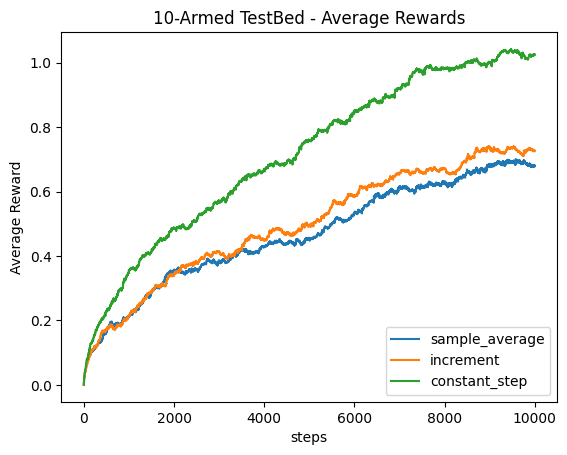

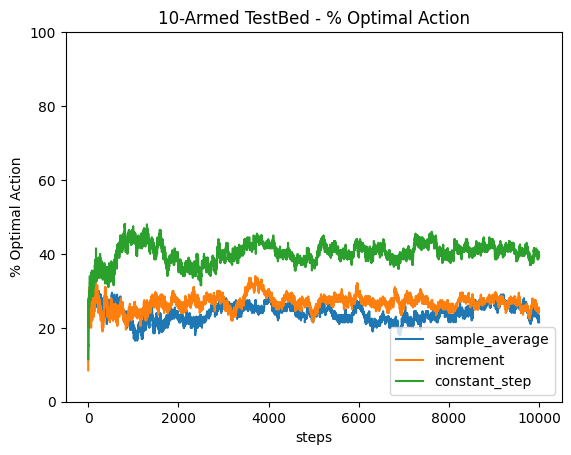

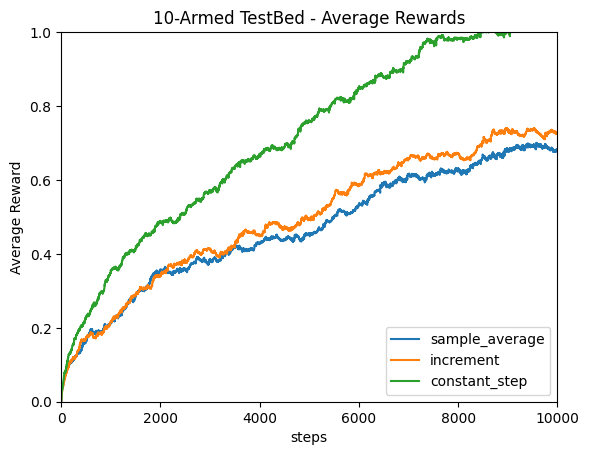

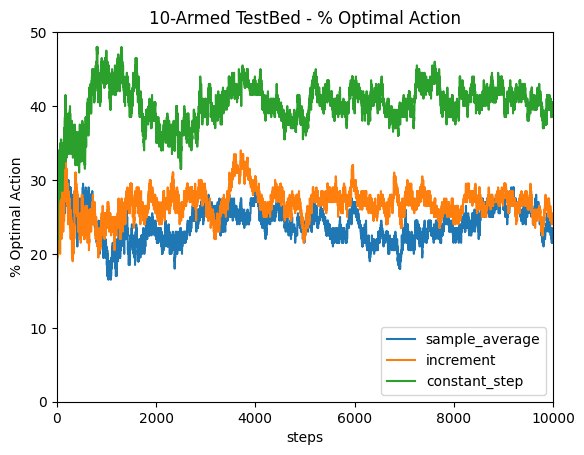

In [12]:
if __name__ == "__main__":
    start_time = time.time()    #store time to monitor execution
    k = 10                  # n number of bandits
    iterations = 200        # number of repeated iterations
    steps = 10000                # number of psteps per iteration

    # Setup objects to contain infomration about the agents, Simulation, and environment
    Simulation = Simulation(k=k,mean=0,sigma=0.01, seed=234)
    agents = [Agent(k=k),Agent(k=k, action_value="increment"),Agent(k=k, action_value="constant_step")]
    environment = Environment(Simulation=Simulation,agents=agents,steps=steps,iterations=iterations)

    #234

    # Run Environment
    print("Running...")
    g1Scores, g2Optimal = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))


    #Graph 1 - Averate rewards over all steps
    plt.title("10-Armed Simulation - Average Rewards")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('steps')
    plt.legend(agents, loc=4)
    plt.show()

    #Graph 1 - optimal selections over all steps
    plt.title("10-Armed Simulation - % Optimal Action")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('steps')
    plt.legend(agents, loc=4)
    plt.show()

    plt.title("10-Armed Simulation - Average Rewards")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('steps')
    plt.ylim(0, 1)
    plt.xlim(0, 10000)
    plt.legend(agents, loc=4)
    plt.show()

    #Graph 1 - optimal selections over all steps
    plt.title("10-Armed Simulation - % Optimal Action")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 50)
    plt.xlim(0, 10000)
    plt.ylabel('% Optimal Action')
    plt.xlabel('steps')
    plt.legend(agents, loc=4)
    plt.show()

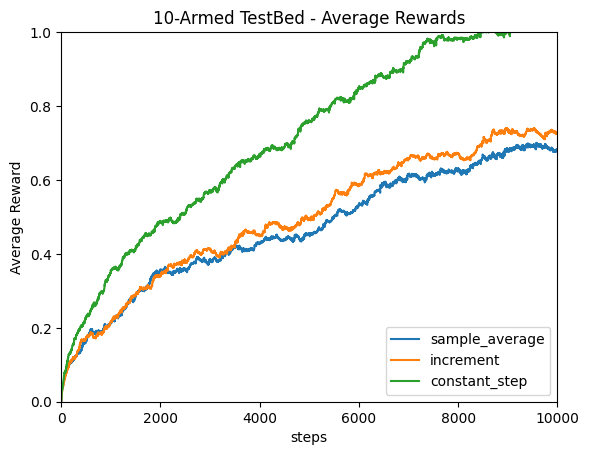

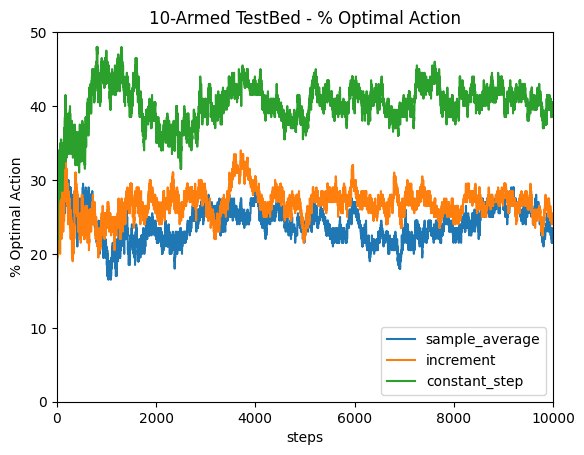

In [13]:
plt.title("10-Armed Simulation - Average Rewards")
plt.plot(g1Scores)
plt.ylabel('Average Reward')
plt.xlabel('steps')
plt.ylim(0, 1)
plt.xlim(0, 10000)
plt.legend(agents, loc=4)
plt.show()

#Graph 1 - optimal selections over all steps
plt.title("10-Armed Simulation - % Optimal Action")
plt.plot(g2Optimal * 100)
plt.ylim(0, 50)
plt.xlim(0, 10000)
plt.ylabel('% Optimal Action')
plt.xlabel('steps')
plt.legend(agents, loc=4)
plt.show()